In [1]:
from Py6S import *
SixS.test()


6S wrapper script by Robin Wilson
Using 6S located at /usr/local/bin/sixsV1.1
Running 6S using a set of test parameters
6sV version: 1.1
The results are:
Expected result: 619.158000
Actual result: 619.158000
#### Results agree, Py6S is working correctly


0

Running for many wavelengths - this may take a long time


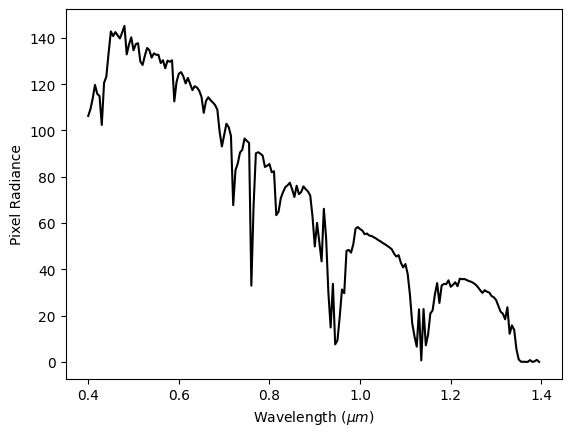

In [3]:
# Create a SixS object called s (used as the standard name by convention)
s = SixS()
# Run the 6S simulation defined by this SixS object across the
# whole VNIR range
wavelengths, results = SixSHelpers.Wavelengths.run_vnir(s, output_name="pixel_radiance")
# Plot these results, with the y axis label set to "Pixel Radiance"
SixSHelpers.Wavelengths.plot_wavelengths(wavelengths, results, "Pixel Radiance")

In [91]:
import random
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt


In [5]:
def calculate_solar_position(latitude, day_of_year, hour):
    # This function calculates the solar zenith and azimuth angles
    # For simplicity, this example uses approximate calculations
    # More accurate calculations would require implementing solar position algorithms
    
    # Convert day of year to angle
    day_angle = 2 * np.pi * (day_of_year - 1) / 365

    # Calculate declination angle
    declination = 23.45 * np.sin(day_angle + (2 * np.pi / 365) * (285 - 80))  # in degrees

    # Calculate time correction for solar noon
    time_correction = 229.18 * (0.000075 + 0.001868 * np.cos(day_angle) - 0.032077 * np.sin(day_angle) 
                                - 0.014615 * np.cos(2 * day_angle) - 0.040849 * np.sin(2 * day_angle))

    # Calculate solar noon (in hours) at the local longitude (assuming longitude is zero for simplicity)
    solar_noon = 12 + (time_correction / 60)

    # Calculate solar hour angle (in degrees)
    hour_angle = 15 * (hour - solar_noon)

    # Calculate solar zenith angle (in degrees)
    solar_zenith_angle = np.degrees(np.arccos(np.sin(np.radians(latitude)) * np.sin(np.radians(declination)) +
                                               np.cos(np.radians(latitude)) * np.cos(np.radians(declination)) *
                                               np.cos(np.radians(hour_angle))))
    
    # Solar azimuth angle calculation is omitted for simplicity
    solar_azimuth_angle = 0

    return solar_zenith_angle, solar_azimuth_angle


In [103]:
def get_solar_irradiance(latitude, longitude, altitude, hour_of_year):
    # Initialize 6S object
    s = SixS()

    # Set the atmospheric profile to US Standard 1962
    s.atmos_profile = AtmosProfile.PredefinedType(AtmosProfile.USStandard1962)

    # Set the ground target altitude in kilometers
    s.altitudes.set_target_custom_altitude(altitude / 1000)  # convert meters to kilometers

    # Convert day of year to month and day
    date = datetime(2023, 1, 1) + timedelta(hours=hour_of_year) - timedelta(days=1)
    day_of_year = date.timetuple().tm_yday

    # Set the geometry, assuming calculate_solar_position provides the correct solar angles
    solar_zenith_angle, solar_azimuth_angle = calculate_solar_position(latitude, day_of_year, hour)
    if solar_zenith_angle >= 90:
        # Sun is below the horizon, so irradiance is zero
        return (0.0, 0.0)

    s.geometry = Geometry.User()
    s.geometry.solar_z = solar_zenith_angle
    s.geometry.solar_a = solar_azimuth_angle
    s.geometry.view_z = 90 - solar_zenith_angle  # Panel perpendicular to the solar beam
    s.geometry.view_a = (solar_azimuth_angle + 180) % 360  # Adjusting view azimuth for perpendicularity
    s.geometry.month = date.month
    s.geometry.day = date.day
    s.geometry.hour = hour
    s.geometry.latitude = latitude
    s.geometry.longitude = 0  # Placeholder, longitude doesn't impact zenith/azimuth in this context

    # Run the simulation
    s.run()

    #print(s.outputs.fulltext)
    # Return the direct solar irradiance
    return (s.outputs.direct_solar_irradiance, s.outputs.diffuse_solar_irradiance)


In [79]:
lat = 42
hour = 12
day = 180
alt = 0
get_solar_irradiance(lat, alt, hour, day)






******************************* 6SV version 1.1 *******************************
*                                                                             *
*                       geometrical conditions identity                       *
*                       -------------------------------                       *
*                       user defined conditions                               *
*                                                                             *
*   month:  6 day :  29                                                       *
*   solar zenith angle:   34.47 deg  solar azimuthal angle:        0.00 deg   *
*   view zenith angle:    55.53 deg  view azimuthal angle:       180.00 deg   *
*   scattering angle:     90.00 deg  azimuthal angle difference: 180.00 deg   *
*                                                                             *
*                       atmospheric model description                         *
*                       -----------

(671.521, 609.192)

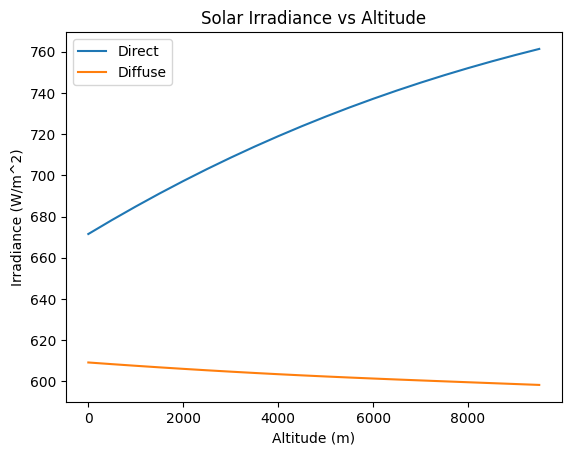

In [48]:
lat = 42
hour = 12
day = 180

rad_by_alt = {}

for alt in range(0, 10000, 500):
    rad_by_alt[alt] = get_solar_irradiance(lat, alt, hour, day)

direct_irradiance = [value[0] for value in rad_by_alt.values()]
diffuse_irradiance = [value[1] for value in rad_by_alt.values()]

plt.plot(rad_by_alt.keys(), direct_irradiance, label='Direct')
plt.plot(rad_by_alt.keys(), diffuse_irradiance, label='Diffuse')
plt.xlabel('Altitude (m)')
plt.ylabel('Irradiance (W/m^2)')
plt.title('Solar Irradiance vs Altitude')
plt.legend()
plt.show()


In [90]:
alt = 524
day = 165
rad_by_hour = []

for hour in range(0, 24):
    irradiance = get_solar_irradiance(lat, alt, hour, day)
    rad_by_hour.append({'Hour': hour, 'inst_direct_w/m': irradiance[0], 'inst_diffuse_w/m': irradiance[1]})

df = pd.DataFrame(rad_by_hour)
df.set_index('Hour', inplace=True)
df['inst_total_w/m'] = df['inst_direct_w/m'] + df['inst_diffuse_w/m']
df['direct_kwh/m'] = df['inst_direct_w/m'] * 0.001 * 24
print(df['direct_kwh/m'].mean())
df

3.481201


,inst_direct_w/m,inst_diffuse_w/m,inst_total_w/m,direct_kwh/m
Hour,,,,
0,0.000,0.000,0.000,0.000000
1,0.000,0.000,0.000,0.000000
2,0.000,0.000,0.000,0.000000
3,0.000,0.000,0.000,0.000000
4,0.000,0.000,0.000,0.000000
5,0.000,0.000,0.000,0.000000
6,0.000,7.019,7.019,0.000000
7,16.756,186.413,203.169,0.402144
8,131.456,356.420,487.876,3.154944


In [92]:
# Constants
earth_circumference_km = 40075
degrees_per_latitude = earth_circumference_km / 360
travel_distance_km = 13 * 3 * 3600 / 1000  # Speed * time * conversion to km

# Latitude steps
degrees_per_step_lat = travel_distance_km / degrees_per_latitude
num_lat_steps = int(360 / degrees_per_step_lat)

# Longitude steps at a representative latitude (e.g., 45 degrees)
representative_lat = 45
degrees_per_longitude_at_lat = np.cos(np.radians(representative_lat)) * degrees_per_latitude
degrees_per_step_lon = travel_distance_km / degrees_per_longitude_at_lat
num_lon_steps = int(360 / degrees_per_step_lon)

num_lat_steps, num_lon_steps

(285, 201)

In [97]:
# Constants for one hemisphere and hour of the year
num_lat_steps = 143  # Half of 285, assuming you're now only considering 0° to 90°
num_lon_steps = 201  # Longitude steps remain the same
num_time_steps = 1456  # Number of 3-hour windows in half a year
num_actions = 9  # Actions remain the same

# Initialize Q-table for one hemisphere and hour of the year
q_table = np.zeros((num_lat_steps, num_lon_steps, num_time_steps, num_actions))

q_table.shape

(143, 201, 1456, 9)

In [110]:
def take_action(state, action):
    lat_index, lon_index, time_index = state
    
    # Defining how each action changes the latitude and longitude index
    action_effects = {
        0: (1, 0),  # 'N'
        1: (1, 1),  # 'NE'
        2: (0, 1),  # 'E'
        3: (-1, 1), # 'SE'
        4: (-1, 0), # 'S'
        5: (-1, -1),# 'SW'
        6: (0, -1), # 'W'
        7: (1, -1), # 'NW'
        8: (0, 0),  # 'STAY'
    }
    
    lat_change, lon_change = action_effects[action]
    
    # Calculate new latitude index, ensuring it's within bounds
    new_lat_index = max(0, min(num_lat_steps - 1, lat_index + lat_change))
    
    # Calculate new longitude index, ensuring it's within bounds
    # This simple wrap-around logic may need adjustment based on your specific requirements
    new_lon_index = (lon_index + lon_change) % num_lon_steps
    
    # Update the time index (assumes 1 step per time increment, adjust if using larger time steps)
    new_time_index = (time_index + 1) % num_time_steps

    return new_lat_index, new_lon_index, new_time_index


In [118]:
def convert_state_to_actual_values(state):
    lat_index, lon_index, time_index = state

    # Assuming latitude is from 0 (equator) to 90 (North Pole) for Northern Hemisphere
    # Adjust if you're using a different range
    actual_lat = (lat_index / num_lat_steps) * 90

    # Assuming longitude is from -180 to 180
    # Adjust the calculation based on your specific longitude range if different
    actual_lon = (lon_index / num_lon_steps) * 360 - 180

    # Convert time index to actual time (hour of the year)
    # If each time step represents 3 hours, adjust the calculation accordingly
    actual_time = time_index * 3  # Adjust this based on your time step duration

    return actual_lat, actual_lon, actual_time


def take_action_and_get_reward(state, action):
    new_state = take_action(state, action)
    # Convert state indices to actual latitude, longitude, and time for irradiance calculation
    # Assuming you have functions or a method to convert indices to actual values
    actual_lat, actual_lon, actual_time = convert_state_to_actual_values(new_state)
    reward = get_solar_irradiance(actual_lat, actual_lon, actual_altitude, actual_time)[0]
    print(new_state, reward)
    return new_state, reward

In [119]:
LEARNING_RATE = 0.1
DISCOUNT_FACTOR = 0.95
EPISODES = 10

actual_altitude = 5400

epsilon = 1.0  # Initial epsilon
epsilon_min = 0.01  # Minimum epsilon value
epsilon_decay = 0.995  # Decay factor

for episode in range(EPISODES):
    initial_time_index = 632 
    initial_lat_index = int(num_lat_steps / 2)
    initial_lon_index = int(num_lon_steps / 2)
    state = (initial_lat_index, initial_lon_index, initial_time_index)  # Initialize the state
    
    print(f"Episode {episode + 1}")
    
    for step in range(num_time_steps):
        print(f"Step {step + 1}")
        # Epsilon-greedy action selection
        if random.uniform(0, 1) < epsilon:
            action = random.randint(0, num_actions - 1)  # Explore
        else:
            action = np.argmax(q_table[state])  # Exploit
        
        # Execute the action
        new_state, reward = take_action_and_get_reward(state, action)
        
        # Update the Q-value
        best_future_q = np.max(q_table[new_state])
        # Ensure that 'state' is a tuple and 'action' is an integer
        q_table[state + (action,)] = q_table[state + (action,)] + \
                                     LEARNING_RATE * (reward + DISCOUNT_FACTOR * best_future_q - q_table[state + (action,)])

        # Transition to the new state
        state = new_state
    
    # Decay epsilon
    epsilon = max(epsilon_min, epsilon_decay * epsilon)


Episode 1
Step 1
(72, 99, 633) 0.0
Step 2
(73, 99, 634) 0.0
Step 3
(72, 100, 635) 0.0
Step 4
(71, 100, 636) 0.0
Step 5
(71, 100, 637) 0.0
Step 6
(72, 99, 638) 0.0
Step 7
(73, 99, 639) 0.0
Step 8
(72, 99, 640) 0.0
Step 9
(72, 100, 641) 0.0
Step 10
(71, 99, 642) 0.0
Step 11
(70, 100, 643) 0.0
Step 12
(70, 101, 644) 0.0
Step 13
(69, 102, 645) 0.0
Step 14
(70, 103, 646) 0.0
Step 15
(70, 104, 647) 0.0
Step 16
(70, 105, 648) 0.0
Step 17
(71, 106, 649) 0.0
Step 18
(72, 105, 650) 0.0
Step 19
(72, 105, 651) 0.0
Step 20
(72, 105, 652) 0.0
Step 21
(71, 105, 653) 0.0
Step 22
(70, 106, 654) 0.0
Step 23
(69, 106, 655) 0.0
Step 24
(68, 106, 656) 0.0
Step 25
(67, 106, 657) 0.0
Step 26
(66, 106, 658) 0.0
Step 27
(65, 105, 659) 0.0
Step 28
(64, 105, 660) 0.0
Step 29
(65, 106, 661) 0.0
Step 30
(65, 106, 662) 0.0
Step 31
(66, 107, 663) 0.0
Step 32
(66, 108, 664) 0.0
Step 33
(66, 109, 665) 0.0
Step 34
(67, 110, 666) 0.0
Step 35
(67, 109, 667) 0.0
Step 36
(66, 109, 668) 0.0
Step 37
(65, 108, 669) 0.0
Step 3